### Data validation of dot data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.signal import medfilt, butter, filtfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend

In [2]:
base = "../data/clean/"
sensor = "dot"

data = {}

## read all files
env_dirs = [entry.name for entry in os.scandir(base) if entry.is_dir()]
print(env_dirs)

for env in env_dirs:
    # gets exp1 and exp2
    exp_dirs = [entry.name for entry in os.scandir(f"{base}/{env}") if entry.is_dir()]
    print(exp_dirs)
    # add an entry for the environment (baseline, flight)
    data[env] = {}
    for e in exp_dirs:
        data[env][e] = {} # add an entry the experimenter
        #path for an experimenter 
        exp_path = f"{base}/{env}/{e}/{sensor}"
        # get the shoes / barefoot dirs
        fw_dirs = [entry.name for entry in os.scandir(exp_path) if entry.is_dir()]
        for f in fw_dirs:
            data[env][e][f] = {} # add an entry for the footwear
            fw_path = f"{exp_path}/{f}"
            # here each activity is a directory with 2 files in it
            data_dirs = [entry.name for entry in os.scandir(fw_path) if entry.is_dir()]
            for d in data_dirs:
                # add an entry for the activity / parabola code
                # will be a list of two df's left and right
                data[env][e][f][d] = []
                data_path = f"{fw_path}/{d}/*.csv"
                
                # array for each data frame left and right
                l_r_dfs = [None, None]
                for file_path in glob.glob(data_path):
                    
                    file_parts = file_path.split("\\")[1].split(".")[0]
                    
                    l_df = ""
                    r_df = ""
                    if(file_parts == "left"):
                        
                        l_df = pd.read_csv(file_path)
                        l_r_dfs[0] = l_df
                    else:
                        r_df = pd.read_csv(file_path)
                        l_r_dfs[1] = r_df

                data[env][e][f][d] = l_r_dfs
                

['baseline', 'flight']
['exp1', 'exp2']
['exp1', 'exp2']


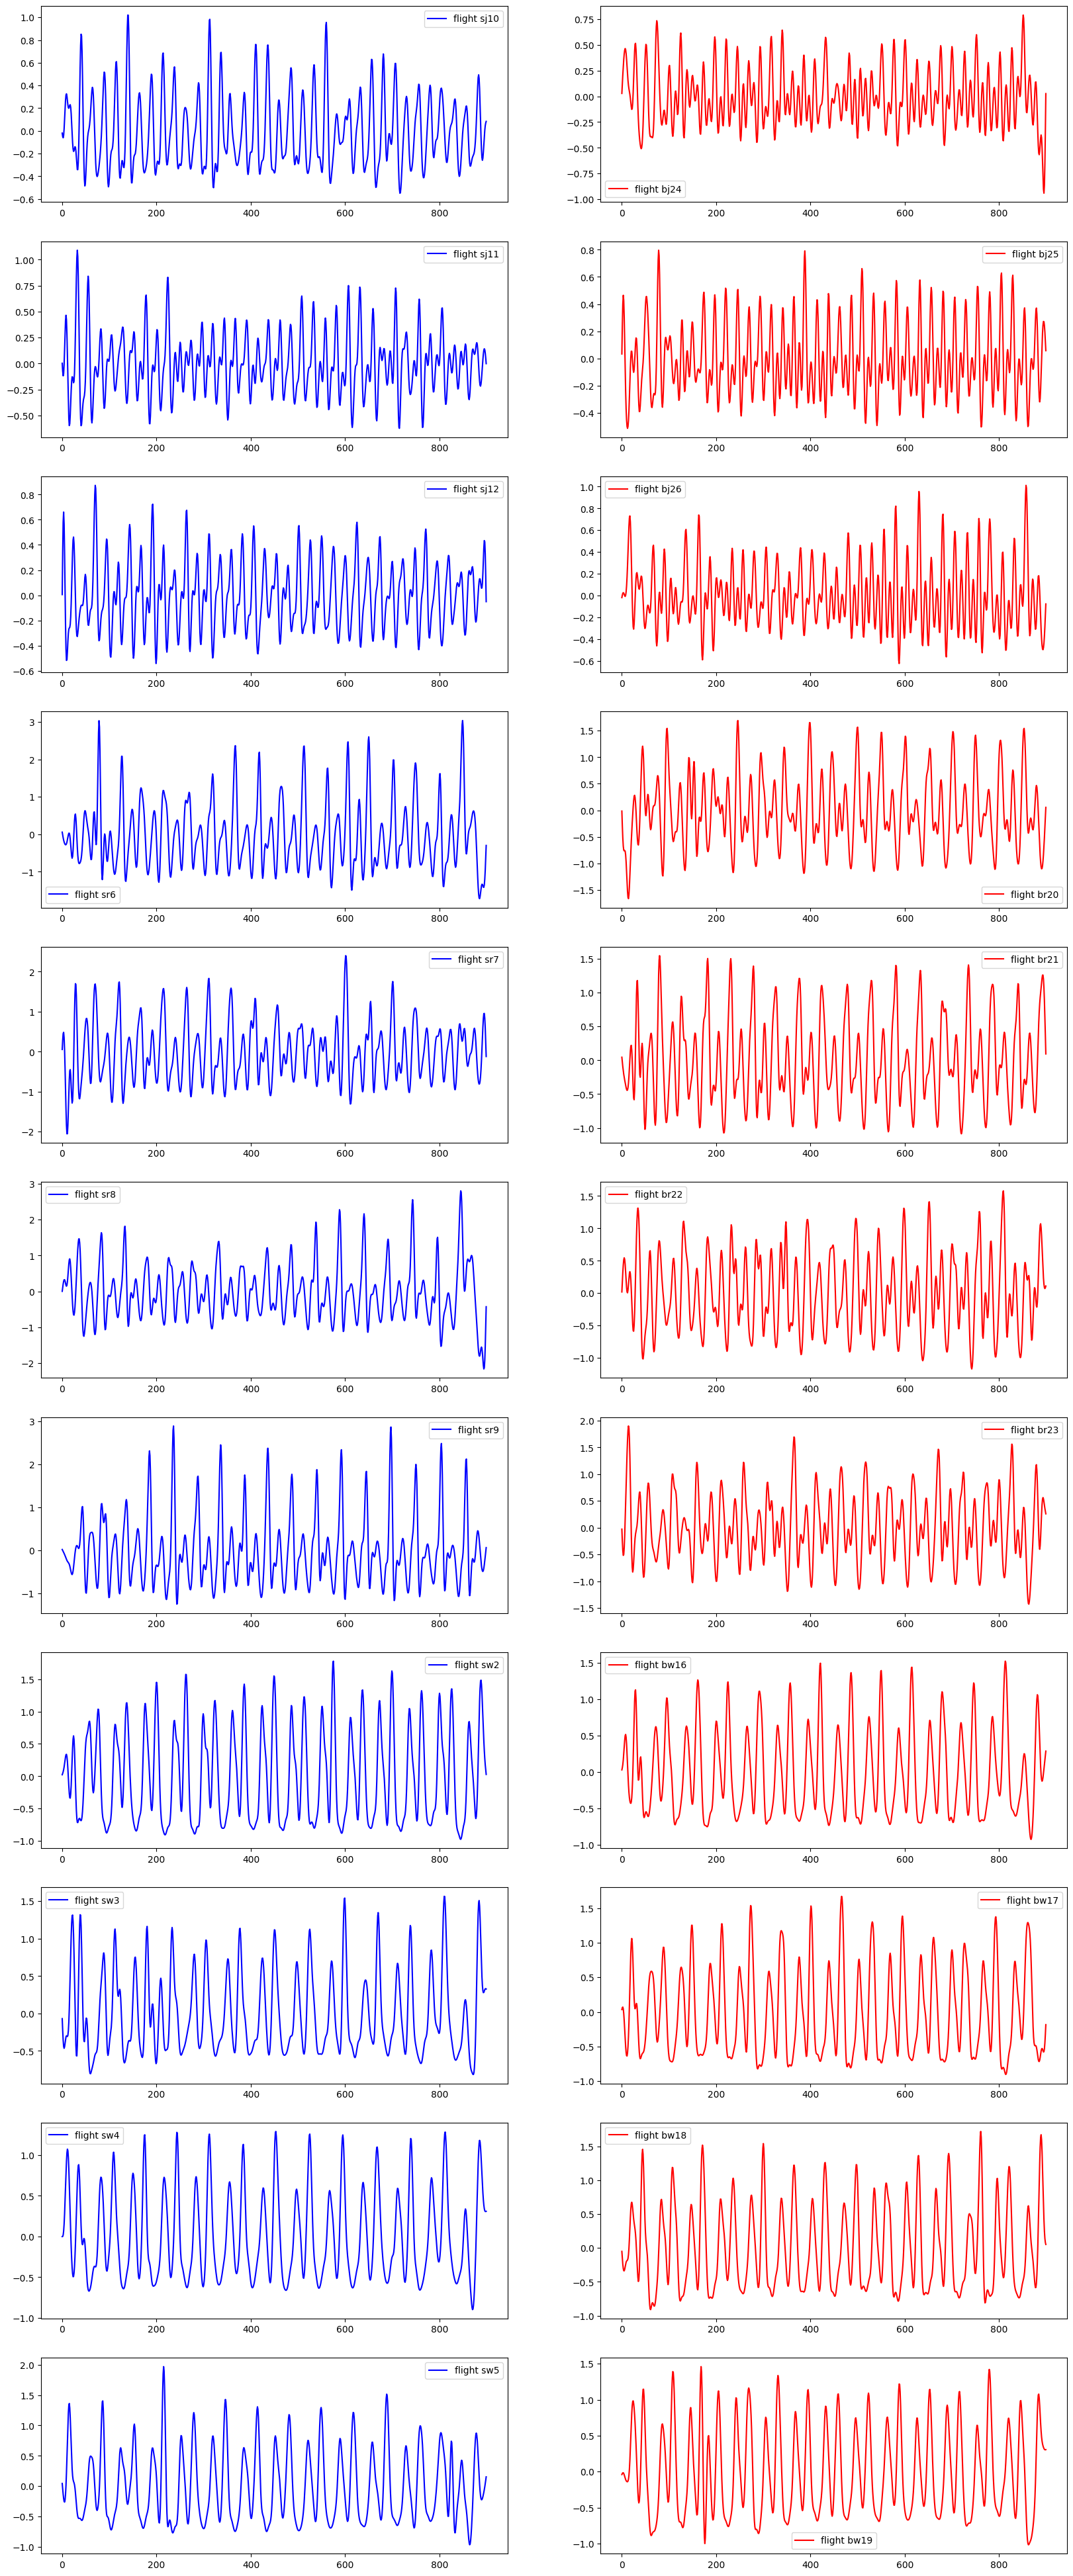

In [6]:
 def vector_magnitude(*args):
    n = len(args[0])
    assert all(len(x) == n for x in args), "Vectors have different lengths"
    vm = np.sqrt(sum(x ** 2 for x in args))
    return vm

def build_filter(frequency, sample_rate, filter_type, filter_order):
    #nyq = 0.5 * sample_rate
    if filter_type == "bandpass":
        #nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
        b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "low":
        #nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1] / ny, btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "high":
        #nyq_cutoff = frequency[0] / nyq
        b, a = butter(filter_order, frequency[0], btype=filter_type, analog=False, output='ba', fs=sample_rate)

    return b, a


def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)
     
exp = 1
env = "flight" 
g = 9.80665

sampling_rate = 60
lc_off = 0.5
hc_off = 6
filter_order = 5
filter_type = "bandpass"

b,a = build_filter((lc_off, hc_off), sampling_rate, filter_type, filter_order)

l_r = 1 # 0 left 1 right
fig, ax = plt.subplots(11,2, figsize=(20, 50))

for idx, d in enumerate(data[env][f"exp{str(exp)}"]["shoes"]):
    x = data[env][f"exp{str(exp)}"]["shoes"][d][l_r]["Acc_X"].to_numpy()/ g
    y = data[env][f"exp{str(exp)}"]["shoes"][d][l_r]["Acc_Y"].to_numpy()/ g
    z = data[env][f"exp{str(exp)}"]["shoes"][d][l_r]["Acc_Z"].to_numpy()/ g
    mag = vector_magnitude(x,y,z)
    mag = filter_signal(b,a, mag, "filtfilt")
    
    #ax[idx][0].plot(data[env][f"exp{str(exp)}"]["shoes"][d][1][direction] / g, label=d, color="blue")
    ax[idx][0].plot(mag, color="blue", label=f"{env} {d}")
    ax[idx][0].legend()
    #ax[idx][0].set_ylim(0,5)

for idx, d in enumerate(data[env][f"exp{str(exp)}"]["barefoot"]):
    x = data[env][f"exp{str(exp)}"]["barefoot"][d][l_r]["Acc_X"].to_numpy()/ g
    y = data[env][f"exp{str(exp)}"]["barefoot"][d][l_r]["Acc_Y"].to_numpy()/ g
    z = data[env][f"exp{str(exp)}"]["barefoot"][d][l_r]["Acc_Z"].to_numpy()/ g
    mag = vector_magnitude(x,y,z)
    mag = filter_signal(b,a, mag, "filtfilt")
    #ax[idx][1].plot(data[env][f"exp{str(exp)}"]["barefoot"][d][1][direction] / g, label=d, color="orange")
    ax[idx][1].plot(mag, color="red", label=f"{env} {d}")
    ax[idx][1].legend()
    #ax[idx][1].set_ylim(0,5)